# Block vs non-block, normalisation vs non-normalisation - One Dimensional analysis, using user RL code and random data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile

Choose a single line as data

In [3]:
dwidth = 2048

In [4]:
data = np.random.randint(0,255,size=dwidth)

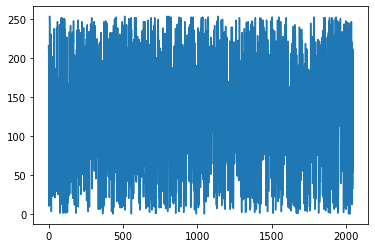

In [5]:
plt.plot(data)

In [7]:
1024+512

1536

## Generate a radnom psf data source

In [15]:
psf_source = np.random.rand(512).astype(np.float32)

In [16]:
psf_source.dtype

dtype('float32')

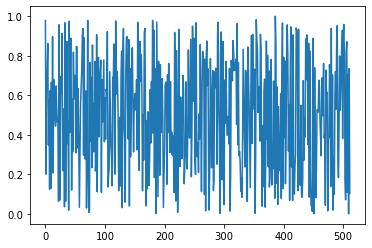

In [17]:
plt.plot(psf_source)

## RL deconvolution, user code

In [18]:
def RL0(data, psf, niter, do_edge_norm=True):
    #print("data.shape :",data.shape)
    #print("psf shape :", psf.shape)
    #Uses normalisation of data for extended size

    #Check data is one dim
    if data.ndim!= 1 and psf.ndim!=1:
        print ("Error: data and/or psf are not 1D. Returning None")
        return None
    
    # #Make sure data shape is even by cropping extra if needed
    # if data.shape[0] % 2 != 0 :
    #     data = data[:-1]
    #     print("new data.shape :",data.shape)

    #make sure psf is normalised sum
    psf0 = psf/ psf.sum()

    #Create a psf-like array that will be used to resize data
    delta_arr = np.zeros_like(psf0)
    phw = int(psf0.shape[0]/2) #Half-width of the psf
    delta_arr[ phw ] = 1.0
    data_shaped = np.convolve(data, delta_arr, mode='full')
    #print("data_shaped shape:", data_shaped.shape)

    #Create a normalisation array
    # a technique that helps slowing the reduction of edge effects with growing niter
    onesarray = np.ones_like(data)
    normarray = np.convolve(onesarray, psf0,mode='full')

    psf0_flip = np.flip(psf0)

    xn1 = np.array(data) #Initialise copy

    for i in range(niter):
        #print("iteration: ", i)
        xn=xn1
        #Convolution at denominator
        u0 = np.convolve(xn, psf0, mode='full')
        #print("u0 shape:", u0.shape)

        #Division
        div0 = data_shaped / u0 #TODO: check sizes are compatible

        #Convolve the result with flipped psf
        u2 = np.convolve(div0,psf0_flip, mode='same') #Use same setting to crop result
        #print("u2 shape:", u2.shape)

        #Multiplication with previous estimation
        #mult0 = np.multiply(xn, u2) #Error in sizes, should use extended previous estimation
        xn_ext = np.convolve(xn, delta_arr, mode='full')
        #print("xn_ext shape:", xn_ext.shape)

        mult0 = np.multiply(xn_ext,u2)

        norm0 = None
        #Optionally divide with normalisation array
        if do_edge_norm==True:
            norm0 = np.divide(mult0, normarray)
        else:
            norm0= mult0

        #crop result
        xn1 = norm0[phw:-phw+1]
        #print("xn1 shape:", xn1.shape)

    res = xn1

    return res

## max_valid_width vs niter and psf size

In [20]:
from scipy import signal
from numpy.random import default_rng
def crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0=512, x_crop_1=1536, niter0=20, psf_half_width0=8 , psf_x_start=200):

    #Get maximum width
    def _get_max_width(data1d):
        maxwidth0=0
        width0=0
        for i in range(data1d.shape[0]):
            v0 = data1d[i]
            if v0==1:
                width0+=1
            else:
                width0==0
            maxwidth0 = max(maxwidth0,width0)
        return maxwidth0

    #create gaussian psf with given width
    psf_width0 = 2*psf_half_width0

    #Uses the data itself to get the psf
    psfdata_crop = psf_source[psf_x_start: psf_x_start+psf_width0]
    psf_norm0 = psfdata_crop / psfdata_crop.sum()

    #x_crop_0, x_crop_1 = 100 , 350
    data_crop0 = data[x_crop_0:x_crop_1]

    #RL deconvolution on the original data and in the cropped data
    deconv_skimageRL0 = RL0(data,psf_norm0, niter0, False)
    deconv_skimageRL_crop0 = RL0(data_crop0,psf_norm0, niter0, False)

    #Get difference and max_width
    diffsq0 = np.power( deconv_skimageRL_crop0 - deconv_skimageRL0[x_crop_0:x_crop_1 ], 2)
    diffsq_valid0 = diffsq0 < 1e-12
    m0 = _get_max_width(diffsq_valid0)
    return m0

In [21]:
#test,1 iteration
crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400, 1000 , 1)

571

## Get maxwidth as a function of number of iterations and psf size

In [22]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth = []
for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 512,1536, niter0, phw0)
        print("niter0: ", niter0 , ", psf_width:", phw0 , ", maxwidth:", maxwidth)
        maxwidths_vs_niter_and_psfhwidth.append( (niter0,phw0,maxwidth) )

niter0:  1 , psf_width: 8 , maxwidth: 994
niter0:  1 , psf_width: 9 , maxwidth: 990
niter0:  1 , psf_width: 10 , maxwidth: 986
niter0:  1 , psf_width: 11 , maxwidth: 982
niter0:  1 , psf_width: 12 , maxwidth: 978
niter0:  1 , psf_width: 13 , maxwidth: 974
niter0:  1 , psf_width: 14 , maxwidth: 970
niter0:  1 , psf_width: 15 , maxwidth: 966
niter0:  1 , psf_width: 16 , maxwidth: 962
niter0:  1 , psf_width: 17 , maxwidth: 958
niter0:  1 , psf_width: 18 , maxwidth: 954
niter0:  1 , psf_width: 19 , maxwidth: 950
niter0:  1 , psf_width: 20 , maxwidth: 946
niter0:  1 , psf_width: 21 , maxwidth: 942
niter0:  1 , psf_width: 22 , maxwidth: 938
niter0:  1 , psf_width: 23 , maxwidth: 934
niter0:  1 , psf_width: 24 , maxwidth: 931
niter0:  1 , psf_width: 25 , maxwidth: 927
niter0:  1 , psf_width: 26 , maxwidth: 923
niter0:  1 , psf_width: 27 , maxwidth: 919
niter0:  1 , psf_width: 28 , maxwidth: 915
niter0:  1 , psf_width: 29 , maxwidth: 911
niter0:  1 , psf_width: 30 , maxwidth: 907
niter0:  1 , 

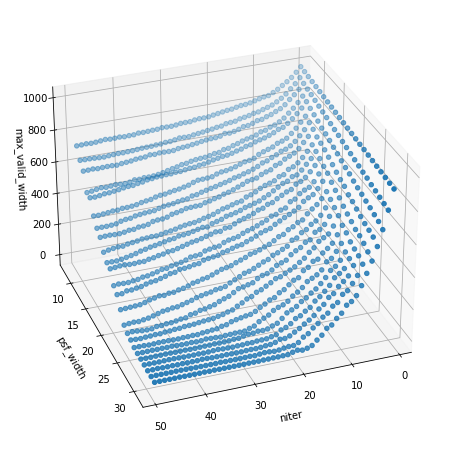

In [23]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth))
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=70)
plt.show()

## Compare with theoretical formula of 'valid' region after convolution

Assumning each RL (2 convolutions) leads to a valid size that is smaller than original data given by formula

$ M_n = m + n(2-2p)$

In [25]:
niter_range = np.arange(1,50)
psf_hwidth_range = np.arange(8,32)

maxwidths_vs_niter_and_psfhwidth_RL= []
maxwidths_vs_niter_and_psfhwidth_theory = []

x_crop_0 = 512
datacrop_width = 1024

print(f"datacrop_width: {datacrop_width}")

for niter0 in niter_range:
    for phw0 in psf_hwidth_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, x_crop_0, x_crop_0+datacrop_width, niter0, phw0)
        maxwidths_vs_niter_and_psfhwidth_RL.append( (niter0,phw0,maxwidth) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_and_psfhwidth_theory.append((niter0,phw0, maxwidth_theory))

        print("niter0: ", niter0 , ", psf_half_width:", phw0 , ", maxwidth:", maxwidth, " maxwidth_theory:", maxwidth_theory)


datacrop_width: 1024
niter0:  1 , psf_half_width: 8 , maxwidth: 994  maxwidth_theory: 994
niter0:  1 , psf_half_width: 9 , maxwidth: 990  maxwidth_theory: 990
niter0:  1 , psf_half_width: 10 , maxwidth: 986  maxwidth_theory: 986
niter0:  1 , psf_half_width: 11 , maxwidth: 982  maxwidth_theory: 982
niter0:  1 , psf_half_width: 12 , maxwidth: 978  maxwidth_theory: 978
niter0:  1 , psf_half_width: 13 , maxwidth: 974  maxwidth_theory: 974
niter0:  1 , psf_half_width: 14 , maxwidth: 970  maxwidth_theory: 970
niter0:  1 , psf_half_width: 15 , maxwidth: 966  maxwidth_theory: 966
niter0:  1 , psf_half_width: 16 , maxwidth: 962  maxwidth_theory: 962
niter0:  1 , psf_half_width: 17 , maxwidth: 958  maxwidth_theory: 958
niter0:  1 , psf_half_width: 18 , maxwidth: 954  maxwidth_theory: 954
niter0:  1 , psf_half_width: 19 , maxwidth: 950  maxwidth_theory: 950
niter0:  1 , psf_half_width: 20 , maxwidth: 946  maxwidth_theory: 946
niter0:  1 , psf_half_width: 21 , maxwidth: 942  maxwidth_theory: 942
n

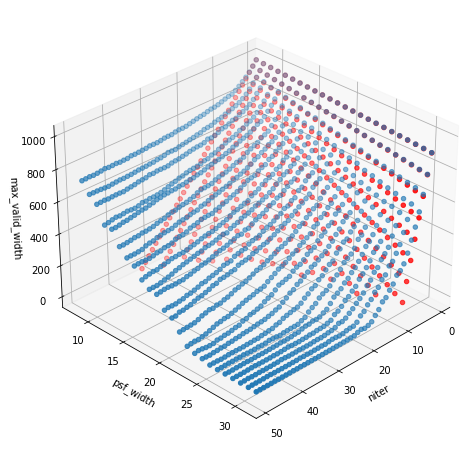

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d', )
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_RL))
ax.scatter(*zip(*maxwidths_vs_niter_and_psfhwidth_theory), c='red')
ax.set_xlabel('niter')
ax.set_zlabel('max_valid_width')
ax.set_ylabel('psf_width')
ax.view_init(azim=45)
plt.show()

In [45]:
maxwidths_vs_niter_and_psfhwidth_RL
# ( niter, psfwidth, maxwidth)

[(1, 8, 994),
 (1, 9, 990),
 (1, 10, 986),
 (1, 11, 982),
 (1, 12, 978),
 (1, 13, 974),
 (1, 14, 970),
 (1, 15, 966),
 (1, 16, 962),
 (1, 17, 958),
 (1, 18, 954),
 (1, 19, 950),
 (1, 20, 946),
 (1, 21, 942),
 (1, 22, 938),
 (1, 23, 934),
 (1, 24, 931),
 (1, 25, 927),
 (1, 26, 923),
 (1, 27, 919),
 (1, 28, 915),
 (1, 29, 911),
 (1, 30, 907),
 (1, 31, 903),
 (2, 8, 964),
 (2, 9, 957),
 (2, 10, 948),
 (2, 11, 940),
 (2, 12, 933),
 (2, 13, 925),
 (2, 14, 917),
 (2, 15, 909),
 (2, 16, 902),
 (2, 17, 893),
 (2, 18, 885),
 (2, 19, 878),
 (2, 20, 869),
 (2, 21, 861),
 (2, 22, 853),
 (2, 23, 845),
 (2, 24, 837),
 (2, 25, 829),
 (2, 26, 823),
 (2, 27, 813),
 (2, 28, 806),
 (2, 29, 798),
 (2, 30, 790),
 (2, 31, 782),
 (3, 8, 936),
 (3, 9, 924),
 (3, 10, 916),
 (3, 11, 901),
 (3, 12, 894),
 (3, 13, 880),
 (3, 14, 868),
 (3, 15, 857),
 (3, 16, 842),
 (3, 17, 835),
 (3, 18, 823),
 (3, 19, 810),
 (3, 20, 799),
 (3, 21, 785),
 (3, 22, 773),
 (3, 23, 764),
 (3, 24, 750),
 (3, 25, 739),
 (3, 26, 730),
 

In [60]:
maxwidths_vs_niter_and_psfhwidth_RL_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL)
filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == 8

In [61]:
filter

array([ True, False, False, ..., False, False, False])

In [62]:

maxwidths_vs_niter_and_psfhwidth_RL_np_filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

In [63]:
maxwidths_vs_niter_and_psfhwidth_RL_np_filtered

array([[  1,   8, 994],
       [  2,   8, 964],
       [  3,   8, 936],
       [  4,   8, 914],
       [  5,   8, 895],
       [  6,   8, 876],
       [  7,   8, 860],
       [  8,   8, 846],
       [  9,   8, 842],
       [ 10,   8, 835],
       [ 11,   8, 827],
       [ 12,   8, 819],
       [ 13,   8, 814],
       [ 14,   8, 812],
       [ 15,   8, 806],
       [ 16,   8, 799],
       [ 17,   8, 796],
       [ 18,   8, 791],
       [ 19,   8, 786],
       [ 20,   8, 781],
       [ 21,   8, 775],
       [ 22,   8, 773],
       [ 23,   8, 773],
       [ 24,   8, 770],
       [ 25,   8, 764],
       [ 26,   8, 764],
       [ 27,   8, 763],
       [ 28,   8, 758],
       [ 29,   8, 755],
       [ 30,   8, 755],
       [ 31,   8, 756],
       [ 32,   8, 751],
       [ 33,   8, 750],
       [ 34,   8, 748],
       [ 35,   8, 746],
       [ 36,   8, 747],
       [ 37,   8, 741],
       [ 38,   8, 741],
       [ 39,   8, 739],
       [ 40,   8, 742],
       [ 41,   8, 740],
       [ 42,   8

In [ ]:
maxwidths_vs_niter_and_psfhwidth_RL_np = np.array(maxwidths_vs_niter_and_psfhwidth_RL)
maxwidths_vs_niter_and_psfhwidth_theory_np = np.array(maxwidths_vs_niter_and_psfhwidth_theory)

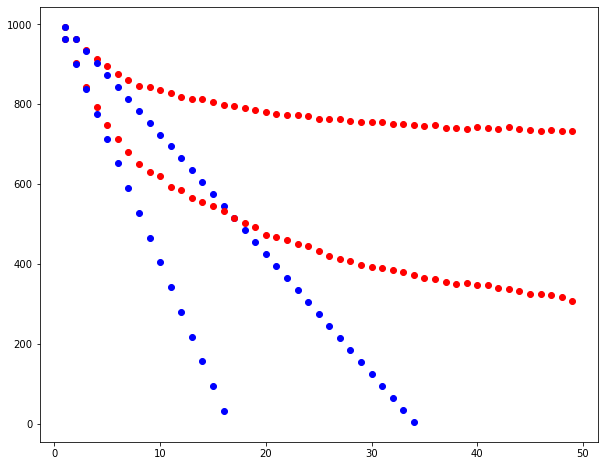

In [78]:
#plot only certain curves
#max_width vs niter of a few psf widths

psf_hwidth_range = [8, 16]


plt.figure(figsize=(10,8))

for phw0 in psf_hwidth_range:
    #Filters data for selected psf width in phw0
    filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

    plt.scatter(filtered[:,0], filtered[:,2], c='red')

    filter =  maxwidths_vs_niter_and_psfhwidth_theory_np[:,1] == phw0
    filtered = maxwidths_vs_niter_and_psfhwidth_theory_np[filter,:]
    plt.scatter(filtered[:,0], filtered[:,2], c='blue')


plt.show()


Try to fit exponential curve to the curve with psfwidth = 16

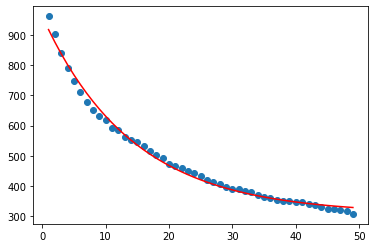

In [87]:
from scipy.optimize import curve_fit

#A = datacrop_width

def exp_func(x,a,b,c):
    return a*np.exp(b*x)+c

filter = maxwidths_vs_niter_and_psfhwidth_RL_np[:,1] == 16
filtered = maxwidths_vs_niter_and_psfhwidth_RL_np[filter,:]

exp_fit_res = curve_fit(exp_func,filtered[:,0], filtered[:,2], p0=(1000,-1,100))

plt.scatter( filtered[:,0], filtered[:,2])
plt.plot(filtered[:,0], exp_func(filtered[:,0], *exp_fit_res[0]), c='red')

In [91]:
exp_fit_res[0] #Fitting parameters [a, b,c] of formula a*np.exp(b*x)+c

array([ 6.53773562e+02, -7.05519858e-02,  3.08620736e+02])

Interesting. The theoretical formula predicts that the decrease in max_valid_width should decrease linearly with niter. This is true at the first niter, but with increasing niter it curves up

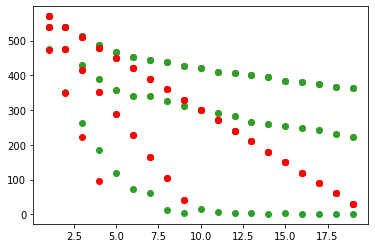

In [28]:
niter_range = np.arange(1,20)
psf_hwidth_range = [8, 16, 32]

maxwidths_vs_niter= []
maxwidths_vs_niter_theor=[]

datacrop_width = data_crop.shape[0]

for phw0 in psf_hwidth_range:
    for niter0 in niter_range:
        maxwidth = crop_vs_noncrop_RL_diff_get_valid_max_width_vs_iter_and_psfsize(data, 400,1000, niter0, phw0)
        maxwidths_vs_niter.append( (niter0,maxwidth) )

        maxwidth_theory = datacrop_width + niter0*(2-4*phw0)
        if maxwidth_theory>0:
            maxwidths_vs_niter_theor.append((niter0, maxwidth_theory))
    plt.scatter(*zip(*maxwidths_vs_niter))
    plt.scatter(*zip(*maxwidths_vs_niter_theor), c='red')

plt.show()
